# Site Object

For a given position, reference wind speed (WS<sub>ref</sub>) and wind direction (WD<sub>ref</sub>), `Site` provides the local wind condition in terms of wind speed (WS), wind direction (WD), turbulence intensity (TI) and the probability of each combination of wind direction and wind speed. Furthermore, `Site` is responsible for calculating the down-wind, cross-wind and vertical distance between wind turbines (which in non-flat terrain is different from the straight-line distances).

**Predefined example sites**

PyWake contains a few predefined sites of different complexities:

- **IEA37Site**: `UniformSite` (fix wind speed (9.8m/s), predefined wind sector probability).
- **Hornsrev1**: `UniformWeibullSite` (Weibull distributed wind speed, predefined wind sector propability, uniform wind a over flat wind area).
- **ParqueFicticioSite**: `WaspGridSite` (position-dependent Weibull distributed wind speed and sector probability. Terrain following distances over non-flat terrain). Loaded from a set of *.grd files exported from WAsP.

**First we import all sites and Python elements for later use**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.examples.data.iea37 import IEA37Site
from py_wake.examples.data.ParqueFicticio import ParqueFicticioSite

sites = {"IEA37": IEA37Site(n_wt=16), 
         "Hornsrev1": Hornsrev1Site(), 
         "ParqueFicticio": ParqueFicticioSite()}

**PyWake also allows for user-defined sites**

You can define your own site using one of the `Site` classes:

- [UniformWeibullSite](#UniformWeibullSite): Site with uniform sector-dependent Weibull distributed wind speed.
- [WaspGridSite](#WaspGridSite): Site with gridded non-uniform inflow based on *.grd files exported from WAsP.
- [XRSite](#XRSite): The flexible general base class behind all Sites.

For more information on these classes, please see the [API reference on the Site object](https://topfarm.pages.windenergy.dtu.dk/PyWake/api/Site.html).

#### UniformWeibullSite

In [3]:
from py_wake.site import UniformWeibullSite

#specifying the necessary parameters for the UniformWeibullSite object
site = UniformWeibullSite(p_wd = [.20,.25,.35,.25],                         # sector frequencies
                          a = [9.176929,  9.782334,  9.531809,  9.909545],  # Weibull scale parameter
                          k = [2.392578, 2.447266, 2.412109, 2.591797],     # Weibull shape parameter
                          ti = 0.1                                          # turbulence intensity, optional
                         )

#### WaspGridSite

In [4]:
from py_wake.site import WaspGridSite
from py_wake.examples.data.ParqueFicticio import ParqueFicticio_path

site = WaspGridSite.from_wasp_grd(ParqueFicticio_path)

#### XRSite

The `XRSite` is the most general and flexible `Site`. For the input dataset there are some required and optional data variables, such as:

- Required data variables:
    - `P`: probability of flow case(s)

    or

    - `Weibull_A`: Weibull scale parameter(s)
    - `Weibull_k`: Weibull shape parameter(s)
    - `Sector_frequency`: Probability of each wind direction sector
    

- Optional data variables:

    - `WS`: Wind speed, if not present, the reference wind speed `ws` is used
    - `Speedup`: Factor multiplied to the wind speed
    - `Turning`: Wind direction turning
    - `TI`: Turbulence intensity
    - xxx: Custom variables needed by the wind turbines to compute power, ct or loads
    

- Each data variable may be constant or depend on a combination of the following inputs (Note, the input variables must be ordered according to the list, i.e. `P(wd,ws)` is ok, while `P(ws,wd)` is not):

    - `i`: Wind turbine position (one position per wind turbine)
    - `x`,`y`: Gridded 2d position
    - `x`,`y`,`h`: Gridded 3d position
    - `time`: Time
    - `wd`: Refernce wind direction
    - `ws` : Reference wind speed

In [5]:
from py_wake.site import XRSite
from py_wake.site.shear import PowerShear
import xarray as xr
import numpy as np
from py_wake.utils import weibull
from numpy import newaxis as na

f = [0.036, 0.039, 0.052, 0.07, 0.084, 0.064, 0.086, 0.118, 0.152, 0.147, 0.1, 0.052]
A = [9.177, 9.782, 9.532, 9.91, 10.043, 9.594, 9.584, 10.515, 11.399, 11.687, 11.637, 10.088]
k = [2.393, 2.447, 2.412, 2.592, 2.756, 2.596, 2.584, 2.549, 2.471, 2.607, 2.627, 2.326]
wd = np.linspace(0, 360, len(f), endpoint=False)
ti = .1

# Site with constant wind speed, sector frequency, constant turbulence intensity and power shear
uniform_site = XRSite(
    ds=xr.Dataset(data_vars={'WS': 10, 'P': ('wd', f), 'TI': ti},
                  coords={'wd': wd}),
    shear=PowerShear(h_ref=100, alpha=.2))

# Site with wind direction dependent weibull distributed wind speed
uniform_weibull_site = XRSite(
    ds=xr.Dataset(data_vars={'Sector_frequency': ('wd', f), 'Weibull_A': ('wd', A), 'Weibull_k': ('wd', k), 'TI': ti},
                  coords={'wd': wd}))

# Site with a speedup and a turning value per WT
x_i, y_i = np.arange(5) * 100, np.zeros(5)  # WT positions

complex_fixed_pos_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': ('i', np.arange(.8, 1.3, .1)),
                   'Turning': ('i', np.arange(-2, 3)),
                   'P': ('wd', f)},
        coords={'i': np.arange(5), 'wd': wd}),
    initial_position=np.array([x_i, y_i]).T)

# Site with gridded speedup information
complex_grid_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': (['x', 'y'], np.arange(.8, 1.4, .1).reshape((3, 2))),
                   'P': ('wd', f)},
        coords={'x': [0, 500, 1000], 'y': [0, 500], 'wd': wd}))

# Site with ws dependent speedup and wd- and ws distributed probability
P_ws = weibull.cdf(np.array([3, 5, 7, 9, 11, 13]), 10, 2) - weibull.cdf(np.array([0, 3, 5, 7, 9, 11]), 10, 2)
P_wd_ws = P_ws[na, :] * np.array(f)[:, na]

complex_ws_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': (['ws'], np.arange(.8, 1.4, .1)),
                   'P': (('wd', 'ws'), P_wd_ws), 'TI': ti},
        coords={'ws': [1.5, 4, 6, 8, 10, 12], 'wd': wd}))

### Gridded non-uniform wind resources as time series with XRSite

This example creates a site with 2D non-uniform time series resources for wind speed (ws), wind direction (wd), and turbulence intensity (ti). The data is provided as arrays with dimensions corresponding to spatial coordinates (x, y) and time.

Mean wind speed at the mean location: 12.04 m/s


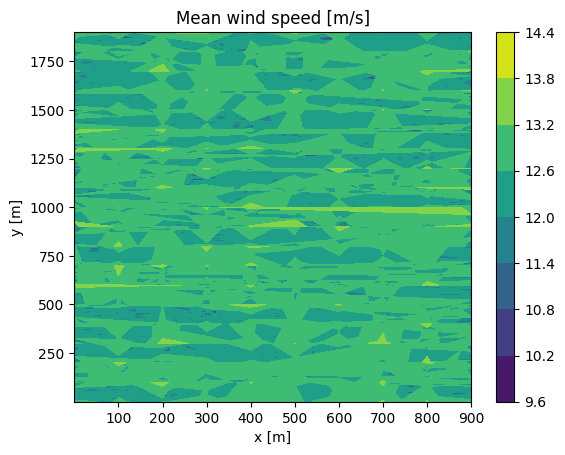

In [6]:
site_x, site_y = np.meshgrid(np.arange(0.1, 1000, 100), np.arange(0.1, 2000, 100))
site_x, site_y = site_x.flatten(), site_y.flatten()
site_time = np.arange(100)
site_ws = np.random.uniform(3.0, 21.0, (len(site_x), len(site_y), len(site_time)))
site_wd = np.random.uniform(0.0, 360.0, (len(site_x), len(site_y), len(site_time)))
ds = xr.Dataset(
    data_vars=dict(
        WS=(["x", "y", "time"], site_ws),
        WD=(["x", "y", "time"], site_wd),
        TI=(["x", "y", "time"], np.ones_like(site_ws) * 0.1),  # hardcoded TI=0.1
        P=1,  # deterministic wind resource
    ),
    coords=dict(
        x=("x", site_x),
        y=("y", site_y),
        time=("time", site_time),
    ),
)
non_uniform_ts_site = XRSite(ds)
wss_at_mean_loc = non_uniform_ts_site.local_wind(
    site_x.mean(), site_y.mean(), time=site_time
)["WS_ilk"]
print(f"Mean wind speed at the mean location: {wss_at_mean_loc.mean():.2f} m/s")

# check the map of the mean wind speed at the site
mean_resource = ds.WS.mean(dim="time").values
plt.contourf(site_x, site_y, mean_resource)
plt.colorbar()
plt.title("Mean wind speed [m/s]")
plt.xlabel("x [m]")
_ = plt.ylabel("y [m]")

## Local wind
The method `local_wind` is used to calculate the local wind in a wind farm given certain turbine positions or coordinates. The class returns a `LocalWind`-dictionary.

In [15]:
localWinds = {name: site.local_wind(x=site.initial_position[:,0],          # x position
                                    y = site.initial_position[:,1],        # y position
                                    h=site.initial_position[:,0]*0+70,     # height
                              ws=None,                                       # defaults to 3,4,..,25
                              wd=None,                                       # defaults to 0,1,...,360
                              ) for name, site in sites.items()}

`LocalWind.coords` contains the current coordinates, e.g.:

- i: Point number. Points can be wind turbine position or just points in a flow map
- wd: Ambient reference wind direction
- ws: Ambient reference wind speed
- x,y,h: position and height of points

while the dictionary itself contains some data variables:

- WD: Local wind direction
- WS: Local wind speed
- TI: Local turbulence intensity
- P: Probability of flow case (wind direction and wind speed)

The `IEA37` site has 16 wind turbines on a uniform site with a fixed wind speed of 9.8 m/s and the data variables therefore only depend on wind direction.

In [16]:
print (localWinds['IEA37'].coords.keys())
localWinds['IEA37'].P

dict_keys(['wd', 'ws', 'i', 'x', 'y', 'h'])


<xarray.DataArray (wd: 360)> Size: 3kB
array([0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00106667, 0.00106667, 0.00106667,
       0.00106667, 0.00106667, 0.00106667, 0.00106667, 0.00106667,
       0.00106667, 0.00106667, 0.00106667, 0.00106667, 0.00106667,
       0.00106667, 0.00106667, 0.00106667, 0.00106667, 0.00106667,
       0.00106667, 0.00106667, 0.00106667, 0.00106667, 0.00128889,
       0.00128889, 0.00128889, 0.00128889, 0.00128889, 0.00128889,
       0.00128889, 0.00128889, 0.00128889, 0.00128889, 0.00128889,
       0.00128889, 0.00128889, 0.00128889, 0.00128889, 0.00128889,
       0.00128889, 0.00128889, 0.00128889, 0.00128889, 0.00128889,
       0.00128889, 0.00128889, 0.0016    , 0.0016    , 0.0016    ,
       0.0016    , 0.0016    , 0.0016    , 0.0016    , 0.0016    ,
       0.0016    , 0.0016    , 0.0016    , 0.0016    , 0.0016    ,
       0.0016    , 0.0016    , 0.0016    , 0.0016    , 0.0016    ,
       0.0016    , 0.0016    , 0.0016    , 0.0016    , 0.0028    ,
       0.0028    , 0.0028    , 0.0028    , 0.0028    , 0.0028    ,
       0.0028    , 0.0028    , 0.0028    , 0.0028    , 0.0028    ,
       0.0028    , 0.0028    , 0.0028    , 0.0028    , 0.0028    ,
       0.0028    , 0.0028    , 0.0028    , 0.0028    , 0.0028    ,
...
       0.00946667, 0.00946667, 0.00946667, 0.00946667, 0.00946667,
       0.00946667, 0.00946667, 0.00946667, 0.00946667, 0.00946667,
       0.00946667, 0.00946667, 0.00946667, 0.00946667, 0.00946667,
       0.00946667, 0.00946667, 0.00946667, 0.00946667, 0.00946667,
       0.00946667, 0.00946667, 0.00204444, 0.00204444, 0.00204444,
       0.00204444, 0.00204444, 0.00204444, 0.00204444, 0.00204444,
       0.00204444, 0.00204444, 0.00204444, 0.00204444, 0.00204444,
       0.00204444, 0.00204444, 0.00204444, 0.00204444, 0.00204444,
       0.00204444, 0.00204444, 0.00204444, 0.00204444, 0.00142222,
       0.00142222, 0.00142222, 0.00142222, 0.00142222, 0.00142222,
       0.00142222, 0.00142222, 0.00142222, 0.00142222, 0.00142222,
       0.00142222, 0.00142222, 0.00142222, 0.00142222, 0.00142222,
       0.00142222, 0.00142222, 0.00142222, 0.00142222, 0.00142222,
       0.00142222, 0.00142222, 0.00097778, 0.00097778, 0.00097778,
       0.00097778, 0.00097778, 0.00097778, 0.00097778, 0.00097778,
       0.00097778, 0.00097778, 0.00097778, 0.00097778, 0.00097778,
       0.00097778, 0.00097778, 0.00097778, 0.00097778, 0.00097778,
       0.00097778, 0.00097778, 0.00097778, 0.00097778, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111])
Coordinates:
  * wd       (wd) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
Attributes:
    description:  Probability of wind flow case (i.e. wind direction and wind...

The `Hornsrev1` site has 80 wind turbines on a uniform site and the data variables therefore depend on wind direction and wind speed.

In [17]:
localWinds['Hornsrev1'].P

<xarray.DataArray (wd: 360, ws: 23)> Size: 66kB
array([[6.14682576e-05, 8.55902794e-05, 1.05949549e-04, ...,
        1.41427496e-07, 5.73800241e-08, 2.19294217e-08],
       [6.14682576e-05, 8.55902794e-05, 1.05949549e-04, ...,
        1.41427496e-07, 5.73800241e-08, 2.19294217e-08],
       [6.14682576e-05, 8.55902794e-05, 1.05949549e-04, ...,
        1.41427496e-07, 5.73800241e-08, 2.19294217e-08],
       ...,
       [6.14682576e-05, 8.55902794e-05, 1.05949549e-04, ...,
        1.41427496e-07, 5.73800241e-08, 2.19294217e-08],
       [6.14682576e-05, 8.55902794e-05, 1.05949549e-04, ...,
        1.41427496e-07, 5.73800241e-08, 2.19294217e-08],
       [6.14682576e-05, 8.55902794e-05, 1.05949549e-04, ...,
        1.41427496e-07, 5.73800241e-08, 2.19294217e-08]], shape=(360, 23))
Coordinates:
  * wd       (wd) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * ws       (ws) int64 184B 3 4 5 6 7 8 9 10 11 ... 17 18 19 20 21 22 23 24 25
Attributes:
    description:  Probability of wind flow case (i.e. wind direction and wind...

Finally, the `ParqueFicticio` site has 8 turbines in a complex terrain and the data variables therefore depend on wind direction, wind speed, and position.

In [18]:
localWinds['ParqueFicticio'].P

<xarray.DataArray (i: 8, wd: 360, ws: 23)> Size: 530kB
array([[[3.30521189e-04, 2.90945174e-04, 2.24051965e-04, ...,
         2.17151164e-12, 4.18358259e-13, 7.59823194e-14],
        [3.29678728e-04, 2.89724248e-04, 2.22255957e-04, ...,
         1.42378793e-12, 2.62971871e-13, 4.56948366e-14],
        [3.28803760e-04, 2.88465466e-04, 2.20425575e-04, ...,
         9.24548089e-13, 1.63531488e-13, 2.71554012e-14],
        ...,
        [3.30774594e-04, 2.93358503e-04, 2.28869097e-04, ...,
         6.51548667e-12, 1.39516685e-12, 2.82983824e-13],
        [3.30714479e-04, 2.92588913e-04, 2.27298658e-04, ...,
         4.55200242e-12, 9.41737928e-13, 1.84263977e-13],
        [3.30630133e-04, 2.91784558e-04, 2.25692881e-04, ...,
         3.15619870e-12, 6.30371964e-13, 1.18883000e-13]],

       [[3.26402880e-04, 2.87997698e-04, 2.21675061e-04, ...,
         1.33860940e-12, 2.44544435e-13, 4.19923483e-14],
        [3.25122046e-04, 2.86441420e-04, 2.19674768e-04, ...,
         8.78625057e-13, 1.53854068e-13, 2.52708344e-14],
        [3.23807130e-04, 2.84847122e-04, 2.17641857e-04, ...,
         5.71244313e-13, 9.57776275e-14, 1.50306673e-14],
...
         4.16918542e-12, 8.45231139e-13, 1.61577818e-13],
        [2.64604401e-04, 2.39695129e-04, 1.89957454e-04, ...,
         2.80824529e-12, 5.47526848e-13, 1.00466686e-13],
        [2.61389307e-04, 2.36466495e-04, 1.86766787e-04, ...,
         1.87054990e-12, 3.50331881e-13, 6.16267761e-14]],

       [[2.68959764e-04, 2.42025369e-04, 1.89572325e-04, ...,
         1.01396181e-12, 1.78631113e-13, 2.94758748e-14],
        [2.67147742e-04, 2.40179522e-04, 1.87608989e-04, ...,
         7.02329489e-13, 1.19181235e-13, 1.89068219e-14],
        [2.65308930e-04, 2.38304775e-04, 1.85622456e-04, ...,
         4.82828262e-13, 7.88535765e-14, 1.20155220e-14],
        ...,
        [2.81699963e-04, 2.54713471e-04, 2.01754861e-04, ...,
         3.67828002e-12, 7.34988224e-13, 1.38414208e-13],
        [2.77506454e-04, 2.50543880e-04, 1.97741116e-04, ...,
         2.42517629e-12, 4.65286805e-13, 8.39650246e-14],
        [2.73260191e-04, 2.46314760e-04, 1.93680118e-04, ...,
         1.57862026e-12, 2.90422137e-13, 5.01516262e-14]]],
      shape=(8, 360, 23))
Coordinates:
  * i        (i) int64 64B 0 1 2 3 4 5 6 7
  * wd       (wd) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * ws       (ws) int64 184B 3 4 5 6 7 8 9 10 11 ... 17 18 19 20 21 22 23 24 25
Attributes:
    description:  Probability of wind flow case (i.e. wind direction and wind...

**Wind speeds at the wind turbines for reference wind speed of 3m/s (k=0):**

- `IEA37`: Constant wind speed of **9.8m/s**
- `Hornsrev1`: Constant wind speed over the site, **3 m/s**
- `ParqueFicticio`: Winds speed depends on both wind direction and position

In [19]:
for name, lw in localWinds.items():
    print (name)
    print (lw.WS.values, 'm/s')
    print ("="*100)

IEA37
9.8 m/s
Hornsrev1
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25] m/s
ParqueFicticio
[[[ 3.78471012  5.04628015  6.30785019 ... 29.01611089 30.27768093
   31.53925096]
  [ 3.80282588  5.07043451  6.33804314 ... 29.15499845 30.42260708
   31.69021571]
  [ 3.82094165  5.09458887  6.36823609 ... 29.29388601 30.56753323
   31.84118045]
  ...
  [ 3.73730114  4.98306819  6.22883524 ... 28.6526421  29.89840915
   31.1441762 ]
  [ 3.75310413  5.00413885  6.25517356 ... 28.77379836 30.02483307
   31.27586779]
  [ 3.76890713  5.0252095   6.28151188 ... 28.89495463 30.151257
   31.40755938]]

 [[ 3.95569235  5.27425647  6.59282059 ... 30.3269747  31.64553882
   32.96410294]
  [ 3.97160588  5.29547451  6.61934314 ... 30.44897845 31.77284708
   33.0967157 ]
  [ 3.98751942  5.31669256  6.64586569 ... 30.5709822  31.90015533
   33.22932847]
  ...
  [ 3.9194794   5.22597253  6.53246567 ... 30.04934207 31.35583521
   32.66232834]
  [ 3.93155038  5.24206718  6.55258397 ... 3

The ParqueFicticio site models variations within the site, so the local wind speed varies over the area.

(np.float64(262878.0),
 np.float64(264778.0),
 np.float64(6504714.0),
 np.float64(6506614.0))

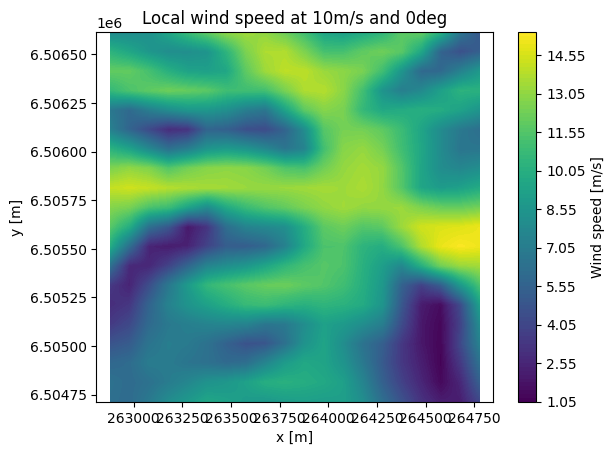

In [20]:
s = sites["ParqueFicticio"]
x = np.linspace(262878,264778,300)
y = np.linspace(6504714,6506614,300)
X,Y = np.meshgrid(x,y)
lw = s.local_wind(X.flatten(),Y.flatten(),30, ws=[10],wd=[0])
Z = lw.WS_ilk.reshape(X.shape)
c = plt.contourf(X,Y,Z, levels=100)
plt.colorbar(c,label='Wind speed [m/s]')
plt.title("Local wind speed at 10m/s and 0deg")
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')

## Distance
**We can also calculate the distance between points of a specific site for either flat or complex terrain.**

For the `IEA37Site` and the `Hornsrev1` sites the distances between points are straight line distances, as these sites are characterized by flat terrain.

For the `ParqueFicticioSite`, on the other hand, the down-wind distance is larger as it follows the non-flat terrain.

In [21]:
wd = [0, 30,90] # wind direction at source

for name, site in sites.items():
    print ("------- %s -------"%name)
    wt_x, wt_y = site.initial_position[0]
    
    dw_ijlk, cw_ijlk, dh_ijlk = site.distance(src_x_ilk=[wt_x], src_y_ilk=[wt_y], src_h_ilk=[70], wd_l=wd,
                                              dst_xyh_jlk=([wt_x], [wt_y-1000], [90]))
    
    print ('Wind direction: \t\t%d deg\t\t%d deg\t\t%d deg'%tuple(wd))
    print ('Down wind distance [m]: \t%.1f\t\t%.1f\t\t%.1f'%tuple(dw_ijlk[0,0,:,0]))
    print ('Cross wind distance [m]: \t%.1f\t\t%.1f\t\t%.1f'%tuple(cw_ijlk[0,0,:,0]))
    dh_ijlk = np.broadcast_to(dh_ijlk, dw_ijlk.shape)
    print ('Height difference [m]: \t\t%.1f\t\t%.1f\t\t%.1f'%tuple(dh_ijlk[0,0,:,0]))
    print()
    

------- IEA37 -------
Wind direction: 		0 deg		30 deg		90 deg
Down wind distance [m]: 	1000.0		866.0		0.0
Cross wind distance [m]: 	0.0		500.0		1000.0
Height difference [m]: 		20.0		20.0		20.0

------- Hornsrev1 -------
Wind direction: 		0 deg		30 deg		90 deg
Down wind distance [m]: 	1000.0		866.0		0.0
Cross wind distance [m]: 	0.0		500.0		1000.0
Height difference [m]: 		20.0		20.0		20.0

------- ParqueFicticio -------
Wind direction: 		0 deg		30 deg		90 deg
Down wind distance [m]: 	1023.6		886.5		-0.0
Cross wind distance [m]: 	0.0		500.0		1000.0
Height difference [m]: 		20.0		20.0		20.0



## Wind resource distribution plots

The `Site` object has a few plot function to visualize its properties, mainly the wind resource given by the wind rose and the probability functions.

In [22]:
import matplotlib.pyplot as plt
site = sites['Hornsrev1']

Plotting wind rose.

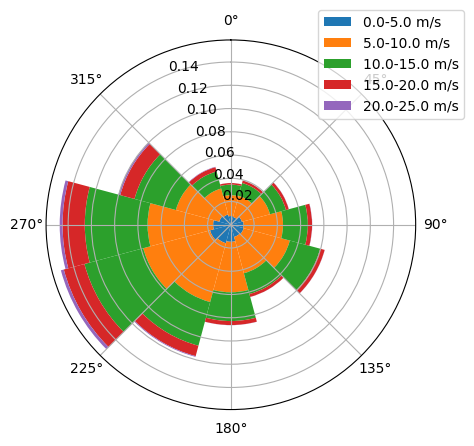

In [23]:
_ = site.plot_wd_distribution(n_wd=12, ws_bins=[0,5,10,15,20,25])

Plotting probability density function for the four sectors studied.

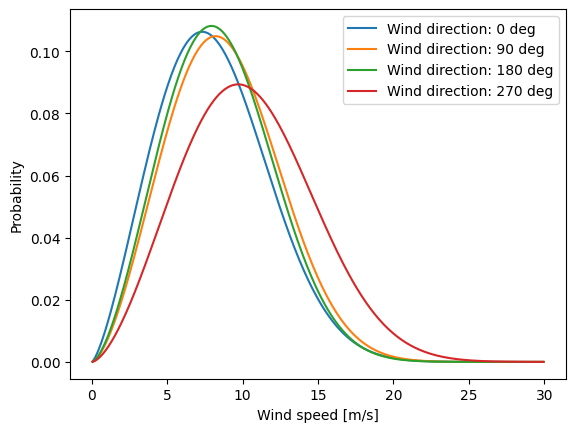

In [24]:
_ = site.plot_ws_distribution(wd=[0,90,180,270])

Plotting probablity density function for the four sector studied $\pm$ 45 degrees.

If **include_wd_distribution=true**, the wind speed probability distributions are multiplied by the wind direction probability.

The sector size is set to 360 / len(wd). This only makes sense if the wd array is evenly distributed

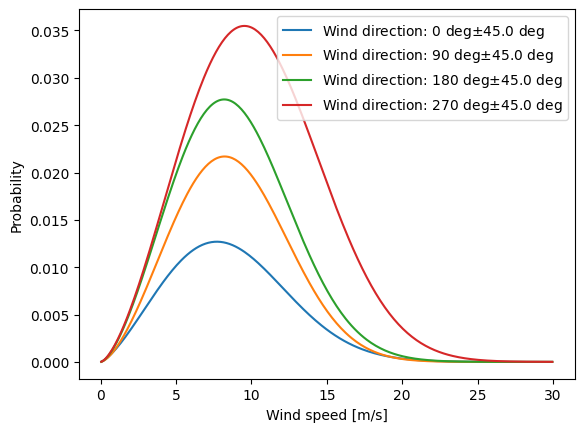

In [25]:
_ = site.plot_ws_distribution(wd=[0,90,180,270], include_wd_distribution=True)